In [27]:
from astropy.modeling import models, Fittable1DModel, Parameter
from astropy.modeling import fitting
import astropy.units as u
import astropy.constants as const

from spectacle.core.spectrum import Spectrum1D
from spectacle.models.custom import Masker

import numpy as np
import matplotlib.pyplot as plt

In [28]:
%matplotlib notebook
plt.rcParams["figure.figsize"] = [8, 8]
# plt.rcParams["figure.dpi"] = 80

# Cropping Absorption Features

In [42]:
# Define the dispersion
wavelength = np.linspace(1210, 1250, 1001) * u.Angstrom
velocity = np.linspace(-800, 800, 1000) * u.Unit("km/s")

def make_cdf(arr, hist=True):
    if hist:
        hist, bin_edges = np.histogram(arr, bins=10000, density=True)
        dx = bin_edges[1] - bin_edges[0]

        return bin_edges[1:], np.cumsum(hist) * dx

    x = np.sort(arr)
    y = np.arange(arr.size)/arr.size
    
    return x, y

# Create the first spectrum with a single line
line1 = dict(name="HI1216", v_doppler=1e6 * u.Unit('cm/s'), 
             column_density=1e13 * u.Unit('1/cm2'))

spectrum1 = Spectrum1D(center=1216).add_line(**line1)

# Create flux and tau profiles with masks
x1_t, y1_t = Masker()(velocity[:-1], spectrum1.tau(velocity[:-1]))
x1_f, y1_f = Masker(continuum=np.ones(velocity.shape))(velocity, spectrum1.flux(velocity))

# Create the second spectrum with a single line
line2 = dict(name="HI1216", v_doppler=1e7 * u.Unit('cm/s'), 
             column_density=1e13 * u.Unit('1/cm2'), 
             delta_v=50000000 * u.Unit('cm/s'))

spectrum2 = Spectrum1D(center=1216).add_line(**line2)

# Create flux and tau profiles with masks
x2_t, y2_t = Masker()(velocity, spectrum2.tau(velocity))
x2_f, y2_f = Masker(continuum=np.ones(velocity.shape))(velocity, spectrum2.flux(velocity))

# Create CDFs for tau spectrum
tx1, ty1 = make_cdf(y1_t, hist=False)
tx2, ty2 = make_cdf(y2_t, hist=False)

# Create CDFs for flux spectrum
x1, y1 = make_cdf(y1_f, hist=False)
x2, y2 = make_cdf(y2_f, hist=False)

<IPython.core.display.Javascript object>


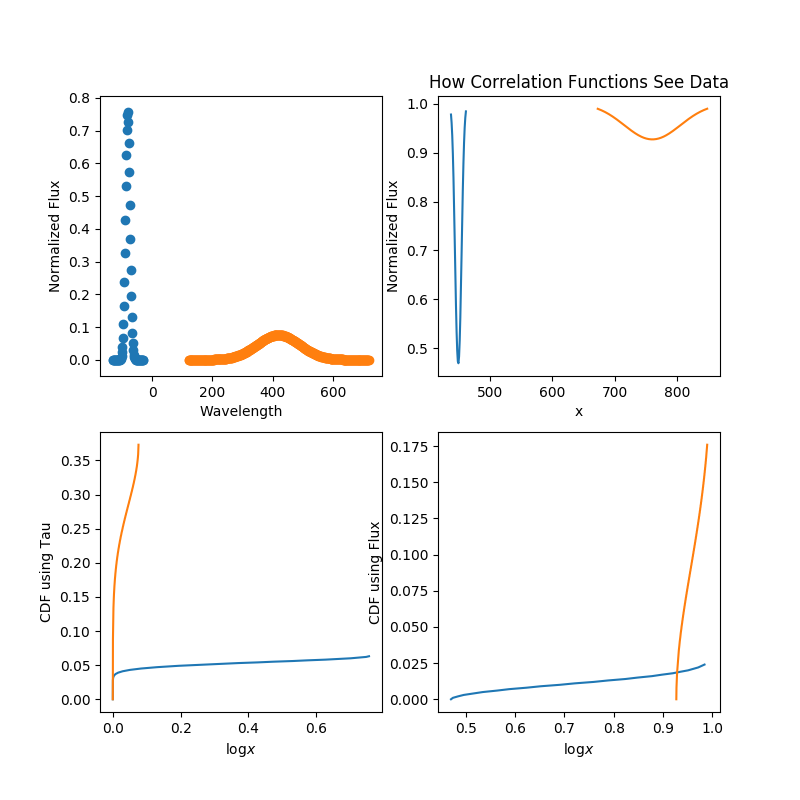

In [43]:
# Generate plots
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
# f.set_size_inches(16, 8)

ax1.scatter(x1_t, y1_t)
ax1.scatter(x2_t, y2_t)

ax2.plot(y1_f)
ax2.plot(y2_f)

ax1.set_xlabel("Wavelength")
ax1.set_ylabel("Normalized Flux")

ax2.set_xlabel("x")
ax2.set_ylabel("Normalized Flux")
ax2.set_title("How Correlation Functions See Data")

ax3.plot(tx1, ty1)
ax3.plot(tx2, ty2)

ax3.set_xlabel("$\log x$")
ax3.set_ylabel("CDF using Tau")

ax4.plot(x1, y1)
ax4.plot(x2, y2)

ax4.set_xlabel("$\log x$")
ax4.set_ylabel("CDF using Flux")

## Control Spectrum

This spectrum acts as the standard to which the dynamic spectrum will be compared in the correlation metrics.

In [44]:
wavelength = np.linspace(1000, 2000, 1001) * u.Angstrom
velocity = np.linspace(-200, 800, 201) * u.Unit('km/s')

In [45]:
# Define the parameter ranges
v_doppler_range = np.logspace(6, 7, 3) * u.Unit('cm/s')
column_density_range = 10 ** np.linspace(13, 14, 3) * u.Unit('1/cm2')
delta_lambda_range = np.linspace(0, 2, 100) * u.Angstrom
delta_v_range = np.linspace(0, 400, 100) * u.Unit('km/s')

def generate(corr_func):
    f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1)
    
    ax1.set_xlabel("$\Delta v$ [km/s]")
    ax1.set_ylabel("Correlation using Flux")
    
    ax2.set_xlabel("Velocity [km/s]")
    ax2.set_ylabel("Normalized Flux")
    
    ax3.set_xlabel("$\Delta v$ [km/s]")
    ax3.set_ylabel("Correlation using Tau")
    
    ax4.set_xlabel("Velocity [km/s]")
    ax4.set_ylabel("Tau")
    
    ax5.set_xlabel("$\Delta v$ [km/s]")
    ax5.set_ylabel("Correlation using\nFlux Decrement")
    
    ax6.set_xlabel("Velocity [km/s]")
    ax6.set_ylabel("Normalized\nFlux Decrement")
    
    f.tight_layout()
    f.subplots_adjust(top=0.9)
    
    # Define the control spectrum. It does not change.
    line1 = dict(lambda_0=1.21567010E+03 * u.Angstrom,
                 gamma=6.2650000e+08, 
                 f_value=4.1640E-01,
                 v_doppler=v_doppler_range[1],
                 column_density=column_density_range[1])

    spectrum1 = Spectrum1D(center=line1['lambda_0']).add_line(**line1)
    
    x, y1_f = Masker(continuum=np.ones(velocity.shape))(velocity, spectrum1.flux(velocity))
    x, y1_t = Masker()(velocity, spectrum1.tau(velocity))
    x, y1_d = Masker()(velocity, spectrum1.flux_decrement(velocity))

    ax2.step(velocity, y1_f)
    ax4.step(velocity, y1_t)
    ax6.step(velocity, y1_d)
    
    def perform_variations(v_dop, col_dens):
        corr, corr_tau, corr_dec = [], [], []

        for dv in delta_v_range:
            line2 = dict(lambda_0=1.21567010E+03 * u.Angstrom,
                         gamma=6.2650000e+08, 
                         f_value=4.1640E-01,
                         v_doppler=v_dop,
                         column_density=col_dens,
                         delta_v=dv)
            
            spectrum2 = Spectrum1D(center=line2['lambda_0']).add_line(**line2)
            
            x, y2_f = Masker(continuum=np.ones(velocity.shape))(velocity, spectrum2.flux(velocity))

            corr.append(corr_func(x, y1_f, y2_f))
            
            x, y2_t = Masker()(velocity, spectrum2.tau(velocity))

            corr_tau.append(corr_func(x, y1_t, y2_t))
            
            x, y2_d = Masker()(velocity, spectrum2.flux_decrement(velocity))

            corr_dec.append(corr_func(x, y1_d, y2_d))
        
        ax2.step(x, y2_f, color='g', alpha=0.5)
        ax4.step(x, y2_t, color='g', alpha=0.5)
        ax6.step(x, y2_d, color='g', alpha=0.5)
        
        return corr, corr_tau, corr_dec
        
    colors = ['b', 'r', 'g']
    line_styles = ['-', '--', '-.']
    
    for i, v_dop in enumerate(v_doppler_range):
        for j, col_dens in enumerate(column_density_range):
            corr, corr_tau, corr_dec = perform_variations(v_dop, col_dens)
            
            ax1.plot(delta_v_range, corr, label="$b=${:g}\n$N=${:g}".format(v_dop, col_dens), 
                     color=colors[i], linestyle=line_styles[j])
            ax3.plot(delta_v_range, corr_tau, label="$b=${:g}\n$N=${:g}".format(v_dop, col_dens), 
                     color=colors[i], linestyle=line_styles[j])
            ax5.plot(delta_v_range, corr_dec, label="$b=${:g}\n$N=${:g}".format(v_dop, col_dens), 
                     color=colors[i], linestyle=line_styles[j])
    
    ax1.legend(bbox_to_anchor=(0.5, 1.75), loc='upper center', ncol=3)

In [ ]:
from spectacle.analysis.metrics import Epsilon
corr_list = generate(lambda x, y1, y2: Epsilon()(y1, y2))

In [ ]:
from spectacle.analysis.metrics import CrossCorrelate
corr_list = generate(lambda x, y1, y2: CrossCorrelate()(y1, y2))

In [ ]:
from spectacle.analysis.metrics import CorrMatrixCoeff
corr_list = generate(lambda x, y1, y2: CorrMatrixCoeff()(y1, y2))

In [ ]:
from spectacle.analysis.metrics import KendallsTau
corr_list = generate(lambda x, y1, y2: KendallsTau()(y1, y2))

In [ ]:
from spectacle.analysis.metrics import KolmogorovSmirnov
corr_list = generate(lambda x, y1, y2: KolmogorovSmirnov()(y1, y2))

In [ ]:
from spectacle.analysis.metrics import AndersonDarling
corr_list = generate(lambda x, y1, y2: AndersonDarling()(y1, y2))

In [46]:
from spectacle.analysis.metrics import DeltaV90
corr_list = generate(DeltaV90())

<IPython.core.display.Javascript object>

NotImplementedError: cannot evaluate truth value of quantities. Evaluate array with q.value.all(...)

In [ ]:

# line1 = dict(lambda_0=1.21567010E+03 * u.Angstrom,
#                      gamma=6.2650000e+08, 
#                      f_value=4.1640E-01,
#                      v_doppler=v_doppler_range[1],
#                      column_density=column_density_range[1])

# spectrum1 = Spectrum1D(center=line1['lambda_0']).add_line(**line1)

# line2 = {}
# line2.update(line1)
# line2.update({'v_doppler': v_doppler_range[2]})
# print(line2)
# spectrum2 = Spectrum1D(center=line1['lambda_0']).add_line(**line2)

# dv90 = DeltaV90()
# print(dv90(velocity, spectrum1.tau(velocity), spectrum2.tau(velocity)))